In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import seaborn as sns


# keras goodies
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras import optimizers

from tensorflow import keras
from pylab import rcParams
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import classification_report
import glob
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

2022-09-09 10:01:46.837662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load data collected by Respeck sensor from students to a DataFrame

In [3]:
#raw_data_folder = ('./raw_data/Respeck_recordings_clean.csv')
raw_data_folder = (glob.glob('./raw_data/**/*.csv', recursive=True))
for filename in raw_data_folder[:]:
    if 'Thingy' in filename:
        raw_data_folder.remove(filename)
    else:
        continue
base_df = pd.DataFrame()

for filename in raw_data_folder:
    # print(filename)
    # load data into a DataFrame
    new_df = pd.read_csv(filename)
    
    # merge into the base DataFrame
    base_df = pd.concat([base_df, new_df])
base_df.reset_index(drop=True, inplace=True)
base_df.columns

In [6]:
#base_df = pd.read_csv(raw_data_folder, encoding='utf-8', delimiter=',')
#base_df.reset_index(drop=True, inplace=True)

Delete augmented index rows due to DataFrame conanation and drop null data

In [5]:
base_df = base_df.loc[:, ~base_df.columns.str.match('Unnamed')]
base_df.drop(columns=['notes'], inplace=True, axis=1)
base_df.dropna(inplace= True)
# df1 = base_df[base_df.isna().any(axis=1)]

Match Class labels from 18 class to grouped 5 class

In [8]:
class_labels = {
    'Descending stairs': None,
    'Running': 'Running',
    'Climbing stairs': None,
    'Walking at normal speed': 'Walking',
    'Lying down on back': 'Lying down',
    'Desk work': None,
    'Sitting bent backward': None,
    'Lying down right': "Lying down",
    'Lying down on stomach': 'Lying down',
    'Lying down left': 'Lying down',
    'Falling on the left': 'Falling',
    'Movement': None,
    'Standing': 'Standing/Sitting',
    'Sitting': 'Standing/Sitting',
    'Falling on knees': 'Falling',
    'Falling on the back': 'Falling',
    'Sitting bent forward': 'Falling',
    'Falling on the right': 'Falling',
}
base_df['activity_type'].replace(class_labels,inplace = True)
base_df = base_df[base_df.activity_type.notnull()]
base_df.reset_index(drop=True, inplace=True)
base_df['activity_type'].unique()


array(['Standing/Sitting', 'Falling', 'Lying down', 'Walking', 'Running'],
      dtype=object)

Data amoount of each class

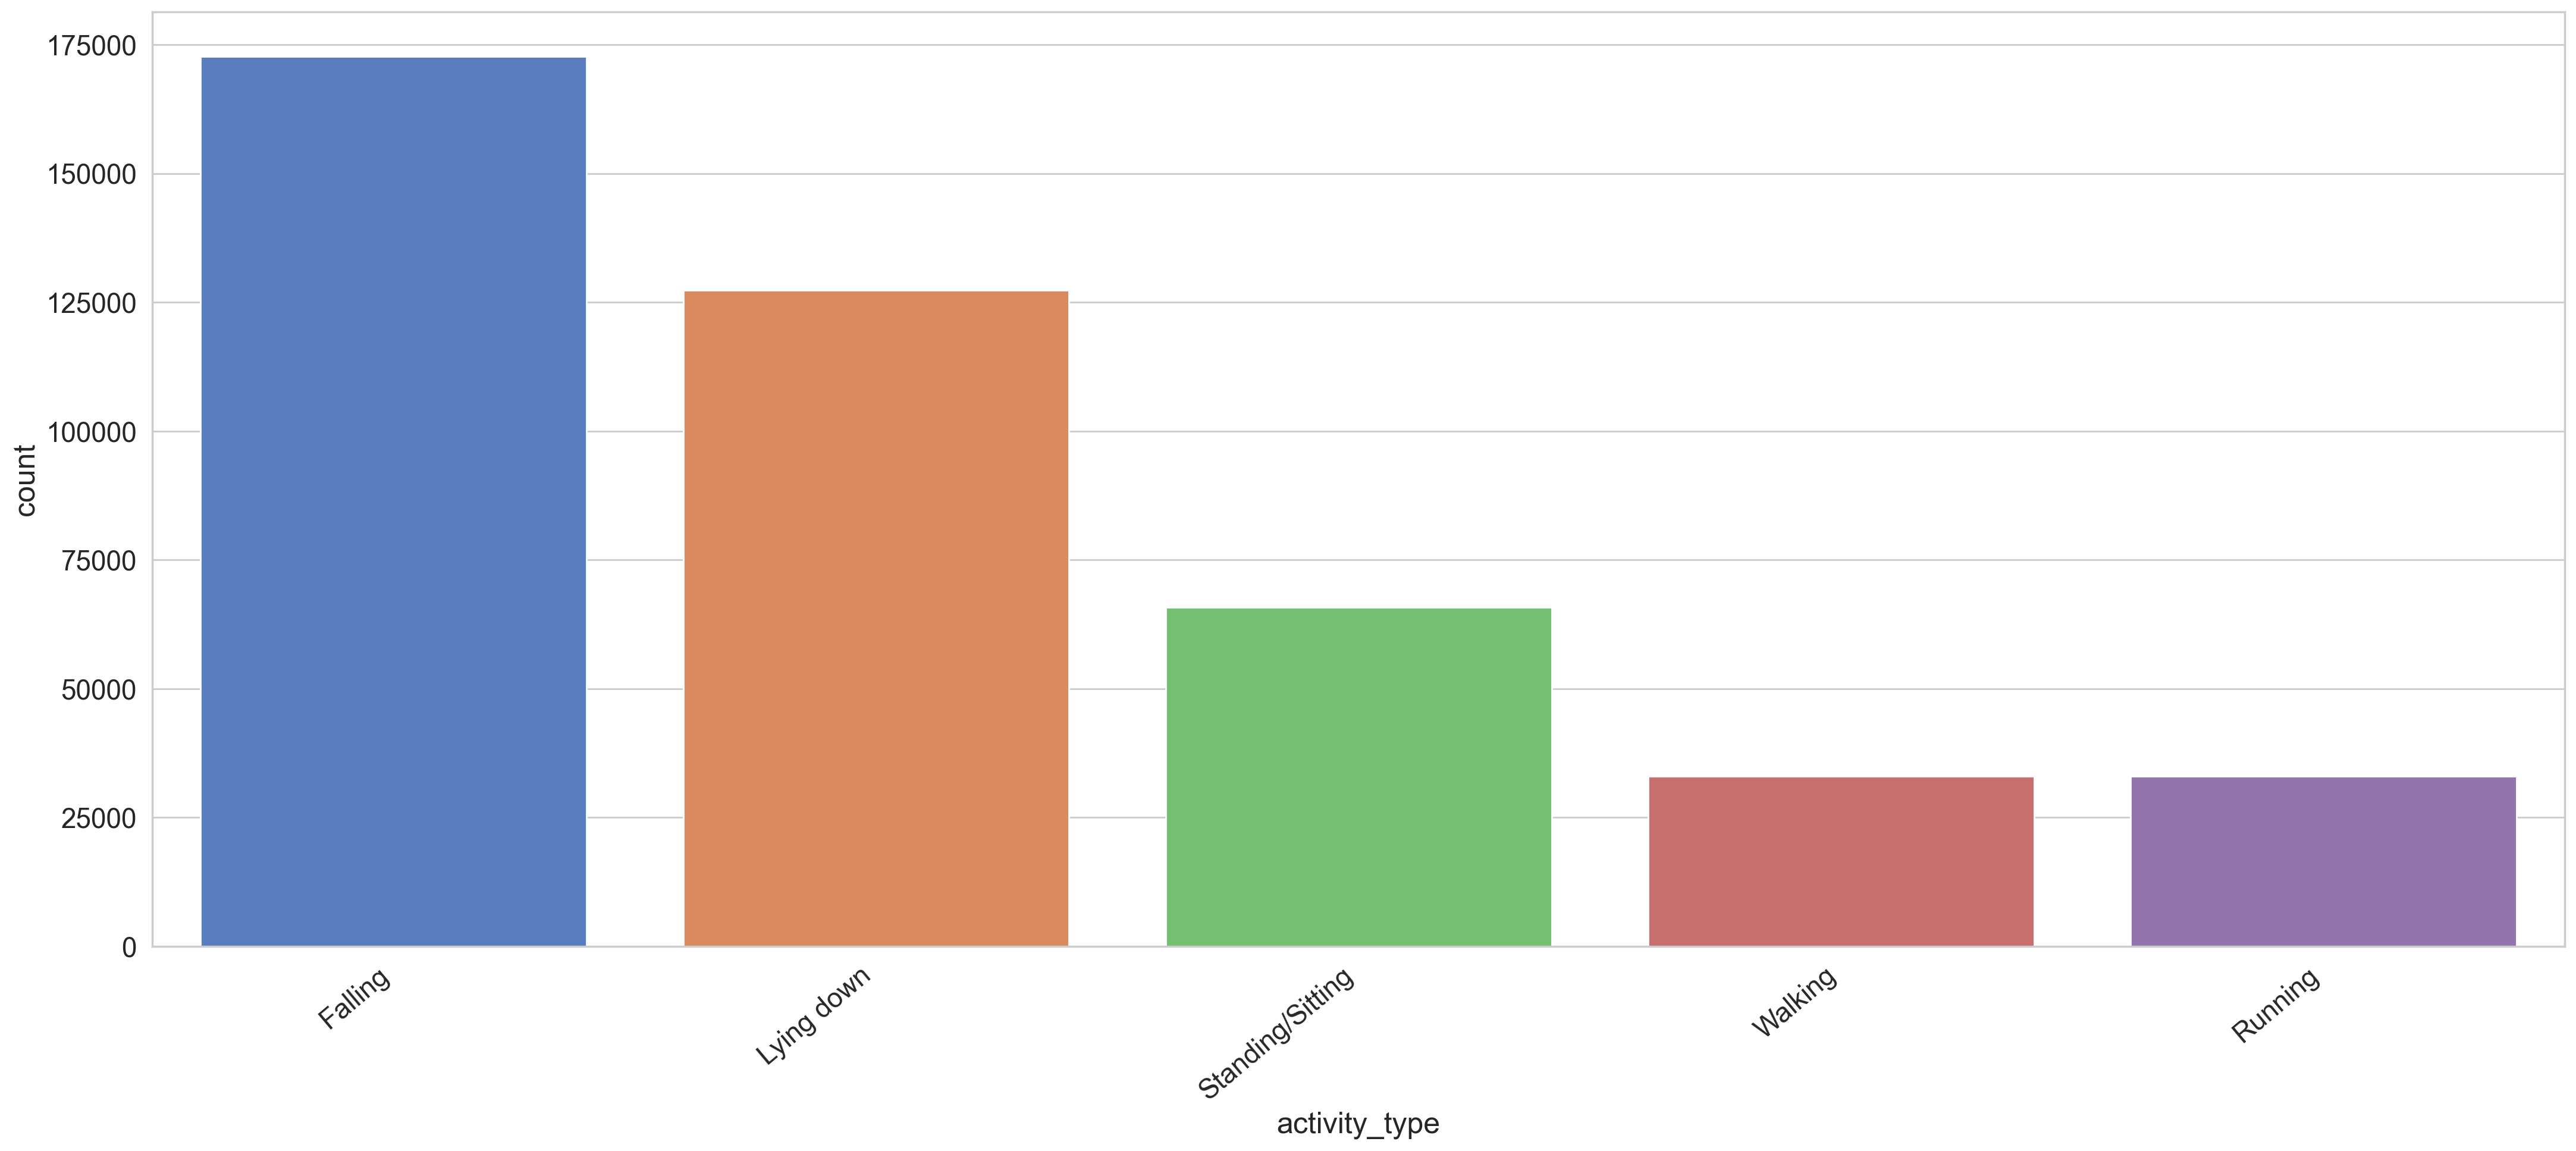

In [11]:
ax = sns.countplot(x = 'activity_type',
              data = base_df,
              order = base_df.activity_type.value_counts().index)


ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha = "right")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Records per subject')

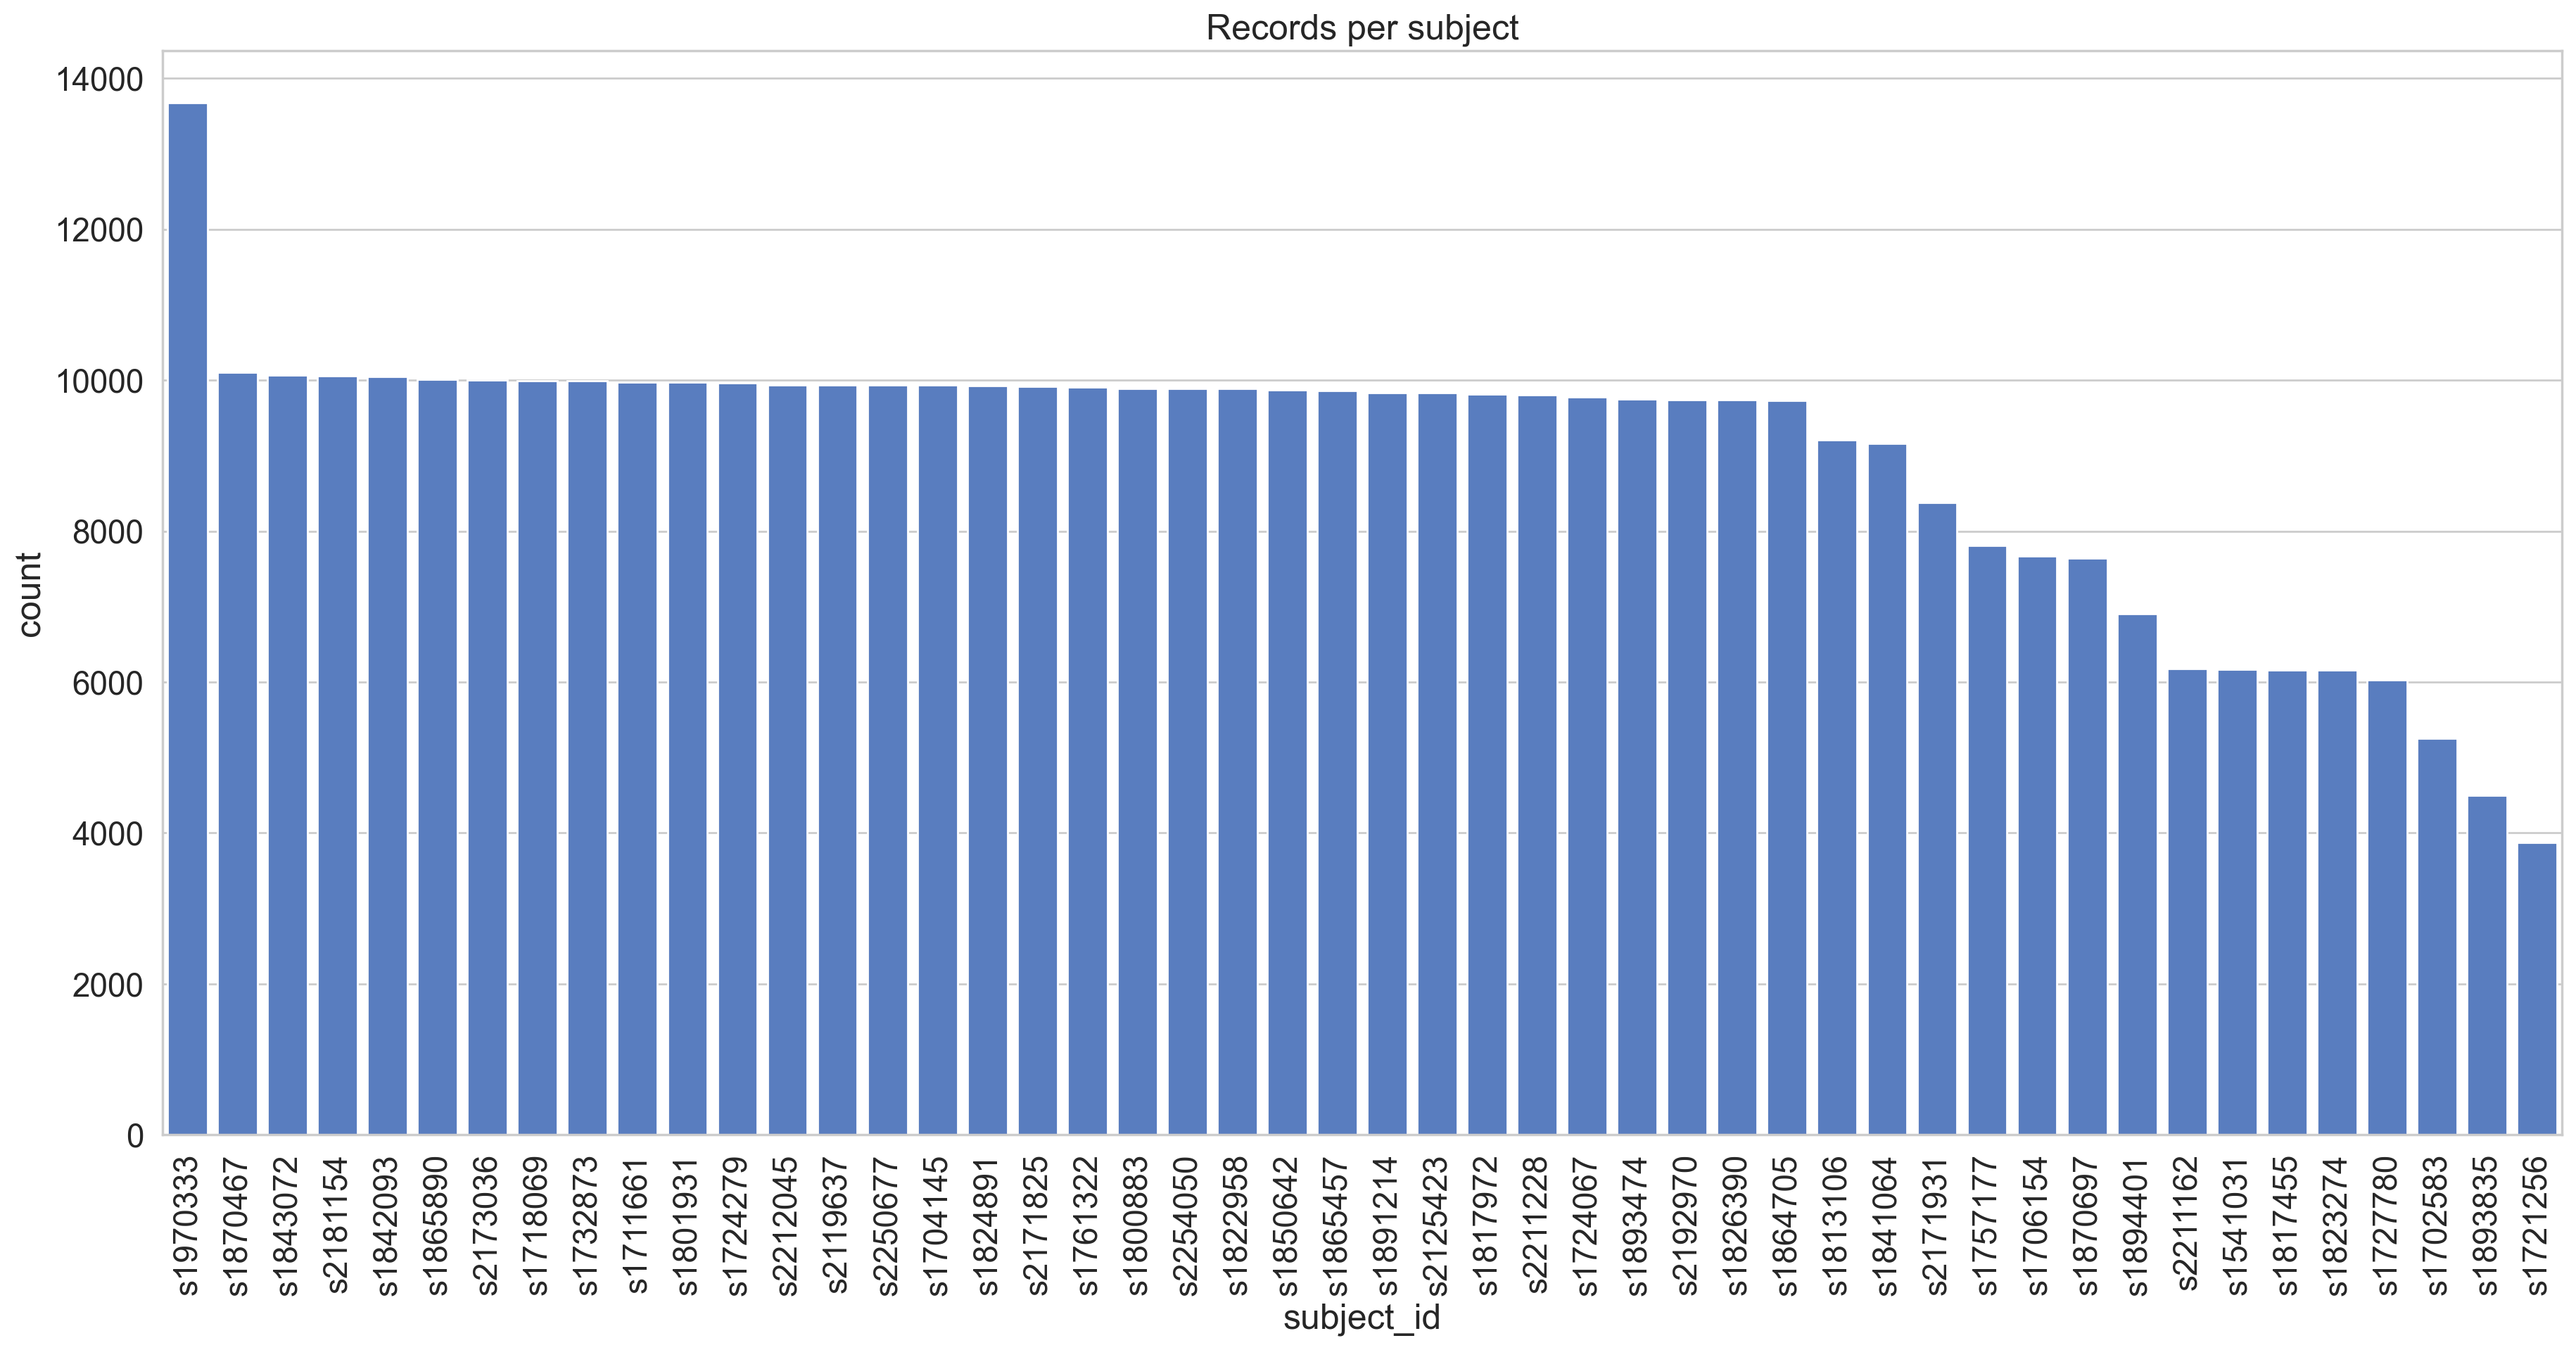

In [10]:
ax = sns.countplot(x = 'subject_id',
              data = base_df,
              palette=[sns.color_palette()[0]],
              order = base_df.subject_id.value_counts().index)
ax.set_xticklabels(labels= ax.get_xticklabels(),rotation=90)
plt.title("Records per subject")

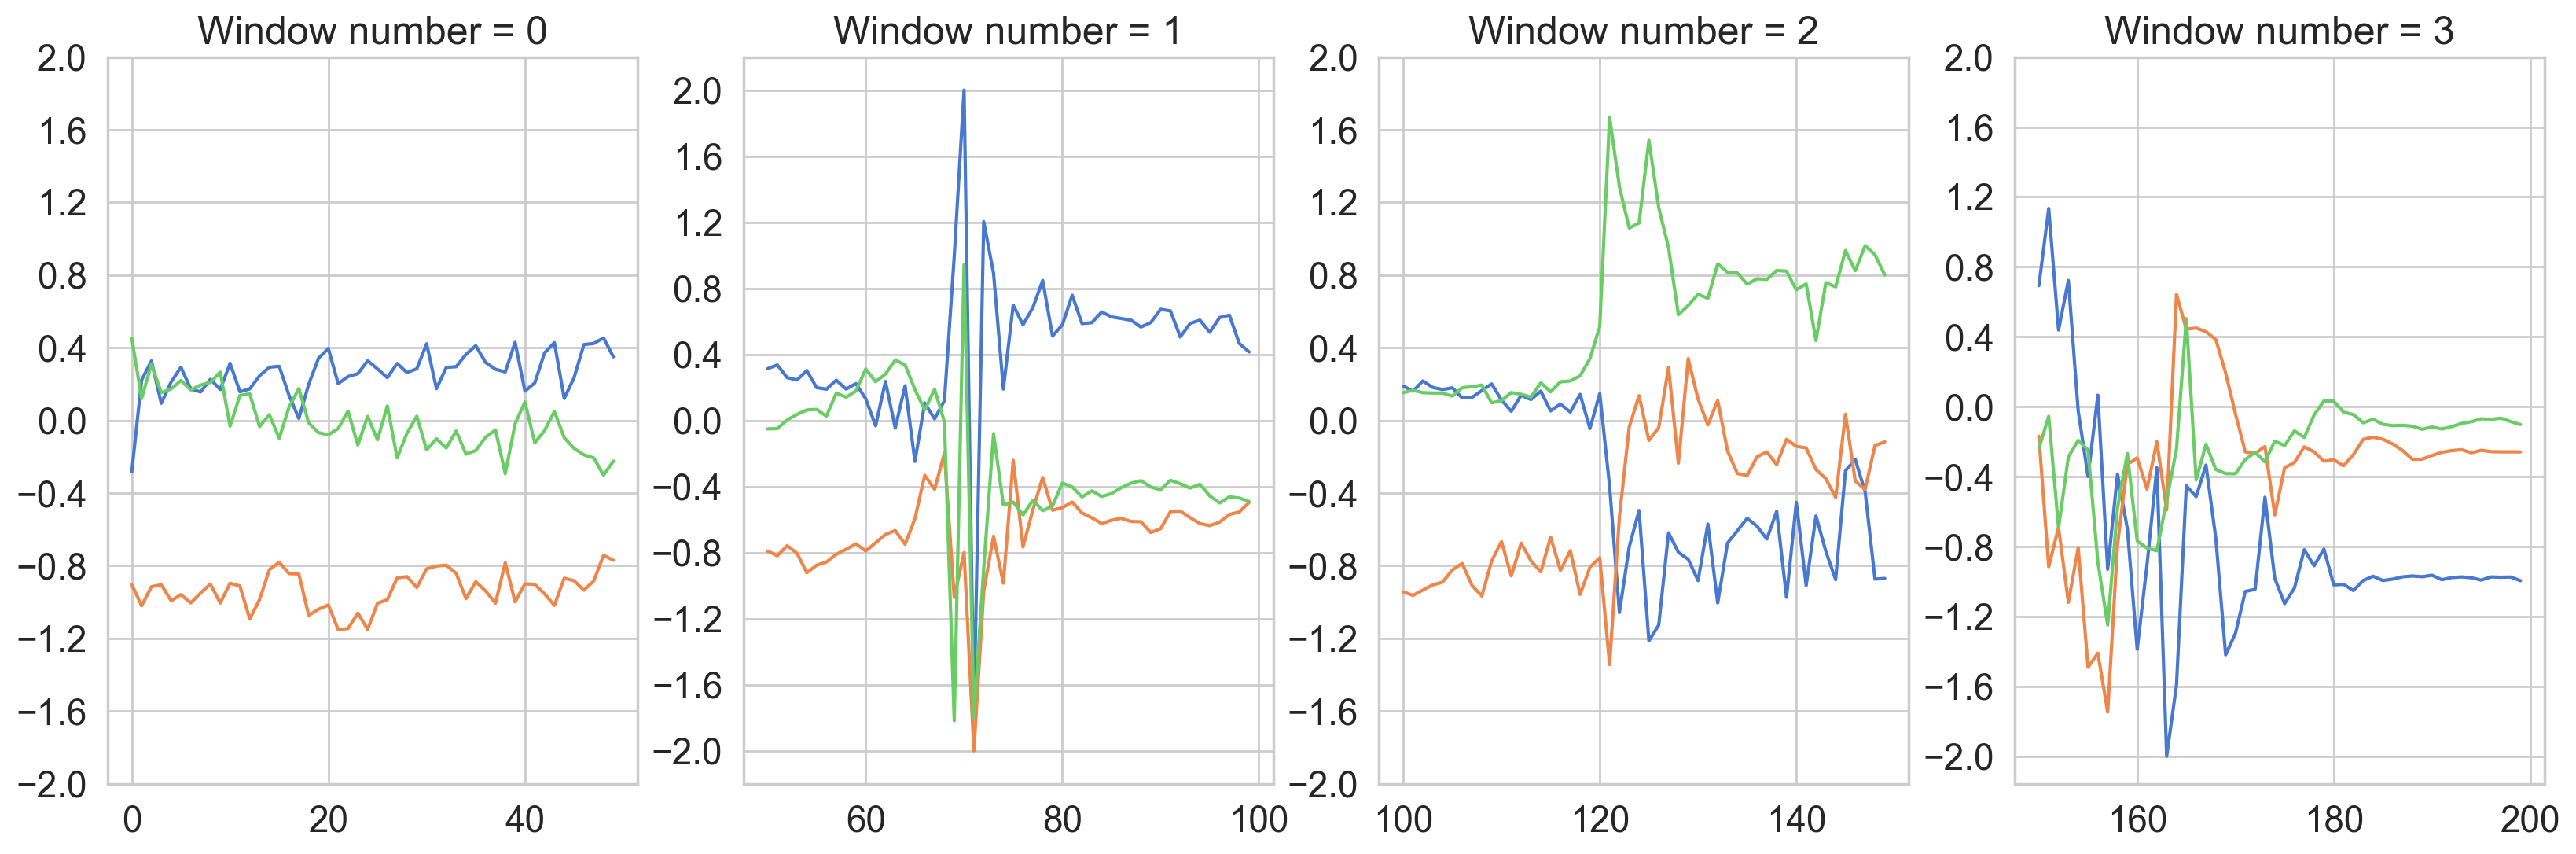

In [18]:
# recordings with different recording ID are recorded in different trails 
# fallings are recorded seprately and concanated together, each falling should lasts longer than 2s
example_recording = base_df.groupby(['recording_id'], as_index=False)

#example_recording

window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # 25 this is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

# for each data chunk belongs to a unique recording id, get overlapped winodws of this data chunk
large_enough_windows = [window for window in example_recording.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

overlapping_windows = large_enough_windows[::step_size] 

for window in overlapping_windows:
    window.loc[:, 'window_id'] = window_number
    window_number += 1

final_sliding_windows = pd.concat(overlapping_windows).reset_index(drop=True)

# plot the fist 4 overlapping windows (the 4 windows may not actually overlap if they are falling data where each recording is short (<3s))
first_four_windows = [group for _, group in final_sliding_windows[final_sliding_windows.window_id < 4].groupby("window_id")]

fig, ax = plt.subplots(1, 4, figsize=(20, 6))

# for i in range(4):
#     ax[i].plot(first_four_windows[i]['gyro_x'])
#     ax[i].plot(first_four_windows[i]['gyro_y'])
#     ax[i].plot(first_four_windows[i]['gyro_z'])
#     ax[i].set_title(f"Window number = {first_four_windows[i].window_id.values[0]}")

for i in range(4):
    ax[i].plot(first_four_windows[i]['accel_x'])
    ax[i].plot(first_four_windows[i]['accel_y'])
    ax[i].plot(first_four_windows[i]['accel_z'])
    ax[i].set_yticks(np.linspace(-2,2,11))
    ax[i].set_title(f"Window number = {first_four_windows[i].window_id.values[0]}")


<bound method NDFrame.head of        timestamp   accel_x   accel_y   accel_z     gyro_x     gyro_y  \
0   1.633532e+12 -0.282471 -0.904602  0.451111   9.078125  39.078125   
1   1.633532e+12  0.222656 -1.020081  0.120544   2.484375 -14.640625   
2   1.633532e+12  0.327393 -0.915344  0.309509   8.984375  13.265625   
3   1.633532e+12  0.093994 -0.904846  0.152771  11.281250   2.062500   
4   1.633532e+12  0.211426 -0.992737  0.173279  -1.828125   2.546875   
5   1.633532e+12  0.292725 -0.959045  0.219910   0.093750   2.656250   
6   1.633532e+12  0.173096 -1.004700  0.167419  -0.125000   0.140625   
7   1.633532e+12  0.156494 -0.950256  0.194519  -4.640625   4.203125   
8   1.633532e+12  0.226318 -0.901184  0.209412  27.203125  17.187500   
9   1.633532e+12  0.170166 -1.005432  0.265808   5.093750  16.062500   
10  1.633532e+12  0.314453 -0.896301 -0.031799  25.984375  15.406250   
11  1.633532e+12  0.157715 -0.911438  0.137390   1.484375  19.125000   
12  1.633532e+12  0.173584 -1.0928

In [12]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
np.array(first_four_windows[0][columns_of_interest]).shape

(50, 6)

In [13]:
window_id_class_labels = final_sliding_windows.groupby(["window_id",'subject_id'])[['activity_type']].agg(np.min)
window_id_class_labels=window_id_class_labels.reset_index()
base_train_df=window_id_class_labels.join(base_df[columns_of_interest])

In [14]:
base_train_df

,window_id,subject_id,activity_type,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
0,0,s1541031,Falling,-0.282471,-0.904602,0.451111,9.078125,39.078125,-8.875000
1,1,s1541031,Falling,0.222656,-1.020081,0.120544,2.484375,-14.640625,9.515625
2,2,s1541031,Falling,0.327393,-0.915344,0.309509,8.984375,13.265625,-0.156250
3,3,s1541031,Falling,0.093994,-0.904846,0.152771,11.281250,2.062500,0.390625
4,4,s1541031,Falling,0.211426,-0.992737,0.173279,-1.828125,2.546875,3.453125
...,...,...,...,...,...,...,...,...,...
11858,11858,s2254050,Lying down,-0.119629,-0.914368,0.417664,-1.656250,4.984375,-0.796875
11859,11859,s2254050,Lying down,-0.124268,-0.894592,0.451599,1.000000,-1.156250,-0.125000
11860,11860,s2254050,Lying down,-0.104004,-0.899963,0.437439,0.093750,2.156250,-1.062500
11861,11861,s2254050,Lying down,-0.106201,-0.913879,0.439636,-0.640625,1.812500,0.765625


In [15]:
#split train and test by subject
def train_test_split(df, split_col, test_fraction):
    split_values = df[split_col].drop_duplicates()
    test_values = split_values.sample(frac=test_fraction, random_state=42)
    
    df_test = df[df[split_col].isin(test_values)]
    df_train = df[~df[split_col].isin(test_values)]
    return df_test, df_train

In [16]:
df_test,df_train=train_test_split(base_train_df,'subject_id',0.2)

In [17]:
df_validation,df_train=train_test_split(df_train,'subject_id',0.05)

In [18]:
print(f"The data was collected for the activities in test set: {df_test.activity_type.unique()}")
print(f"The subject IDs in test set are: {len(df_test.subject_id.unique())}")
print(f"The data was collected for the activities in train set: {df_train.activity_type.unique()}")
print(f"The subject IDs in the train set are: {len(df_train.subject_id.unique())}")
print(f"The data was collected for the activities in val set: {df_validation.activity_type.unique()}")
print(f"The subject IDs in val set are: {len(df_validation.subject_id.unique())}")

The data was collected for the activities in test set: ['Falling' 'Lying down' 'Running' 'Standing/Sitting' 'Walking']
The subject IDs in test set are: 10
The data was collected for the activities in train set: ['Falling' 'Lying down' 'Walking' 'Running' 'Standing/Sitting']
The subject IDs in the train set are: 36
The data was collected for the activities in val set: ['Lying down' 'Running' 'Falling' 'Standing/Sitting' 'Walking']
The subject IDs in val set are: 2


In [19]:
#from sklearn.preprocessing import RobustScaler

#scale_columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
#scaler = RobustScaler()

#scaler = scaler.fit(df_train[scale_columns])

#df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
#df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

In [20]:
X = []
y = []

for window_id, group in final_sliding_windows.groupby('window_id'):    
    shape = group[columns_of_interest].values.shape    
    X.append(group[columns_of_interest].values)
    y.append(group["activity_type"].values[0])

In [21]:
X = np.asarray(X)
y = np.asarray(y)

In [22]:
myset = set(y)
myset

{'Falling', 'Lying down', 'Running', 'Standing/Sitting', 'Walking'}

In [23]:
print(f"X shape = {X.shape}")
print(f"y shape = {y.shape}")

X shape = (11863, 50, 6)
y shape = (11863,)


In [24]:
X_train=X[df_train.index]
y_train=y[df_train.index]

X_test=X[df_test.index]
y_test=y[df_test.index]

X_validation=X[df_validation.index]
y_validation=y[df_validation.index]

In [25]:
y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)
y_validation = np.asarray(pd.get_dummies(y_validation), dtype=np.float32)

In [26]:
print(f"X_train shape = {X_train.shape}")
print(f"y_train shape = {y_train.shape}")

print(f"X_test shape = {X_test.shape}")
print(f"y_test shape = {y_test.shape}")

print(f"X_validation shape = {X_validation.shape}")
print(f"y_validation shape = {y_validation.shape}")

X_train shape = (8789, 50, 6)
y_train shape = (8789, 5)
X_test shape = (2558, 50, 6)
y_test shape = (2558, 5)
X_validation shape = (516, 50, 6)
y_validation shape = (516, 5)


## GRU

In [27]:
filters = 64
kernel_size = 3
n_features = 6
activation='relu'
n_classes = 5
hidden_units = 64
time_steps = 5

In [28]:
from tensorflow.keras.layers import GRU
from keras.models import Sequential
from keras.layers import (
    LSTM,
    Bidirectional,
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Activation,
    Dropout,
    BatchNormalization
)
model = Sequential()
model.add(GRU(128,input_shape=[50,6],dropout=0.2,use_bias=True,return_sequences=True,activation='relu'))
model.add(GRU(64, use_bias=True, dropout=0.2, activation='relu'))
#model.add(BatchNormalization())
#model.add(Flatten())
#model.add(Dense(28, activation='relu'))
model.add(Dense(n_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 128)           52224     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 89,797
Trainable params: 89,797
Non-trainable params: 0
_________________________________________________________________


In [29]:
optim = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'] )

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=30)
history = model.fit(X_train, y_train,batch_size=256, epochs=100,callbacks=[callback],
                    validation_data=(X_validation, y_validation))


Epoch 1/100
35/35 [==============================] - 26s 660ms/step - loss: 1.8206 - accuracy: 0.1410 - val_loss: 1.5363 - val_accuracy: 0.1512

In [31]:
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

In [32]:
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.92      0.76      0.83       521
           1       0.96      0.94      0.95       991
           2       0.94      0.99      0.97       283
           3       0.83      1.00      0.91       507
           4       0.98      0.95      0.96       256

    accuracy                           0.92      2558
   macro avg       0.93      0.93      0.92      2558
weighted avg       0.93      0.92      0.92      2558



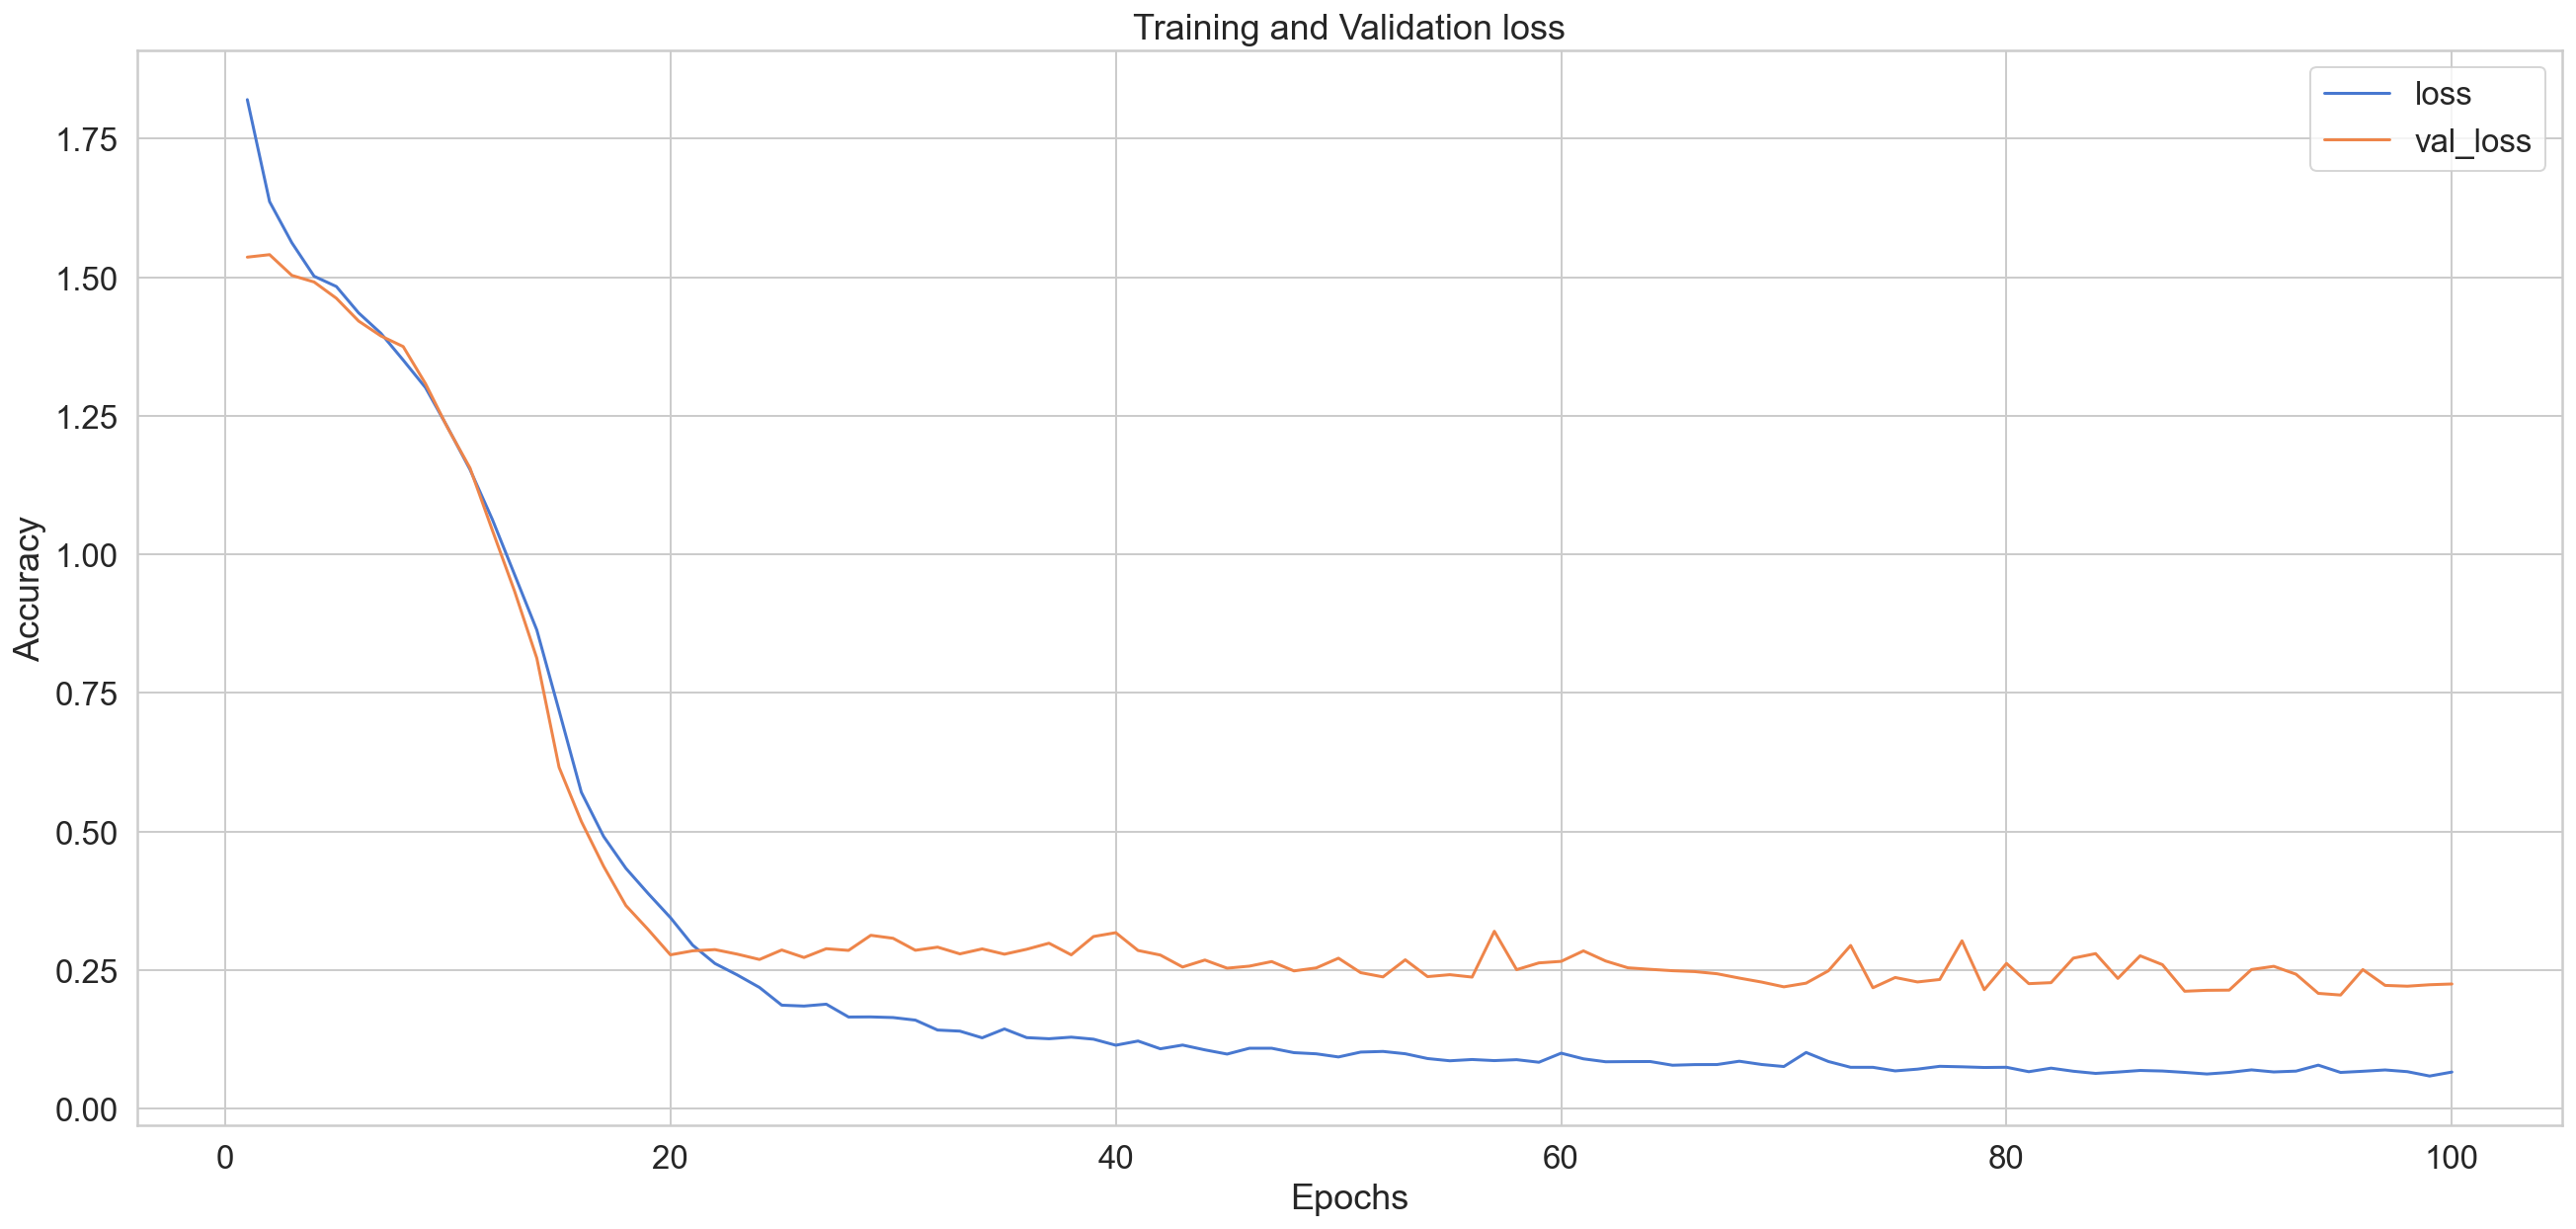

In [33]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_train)+1)
plt.plot(epochs, loss_train, label='loss')
plt.plot(epochs, loss_val, label='val_loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

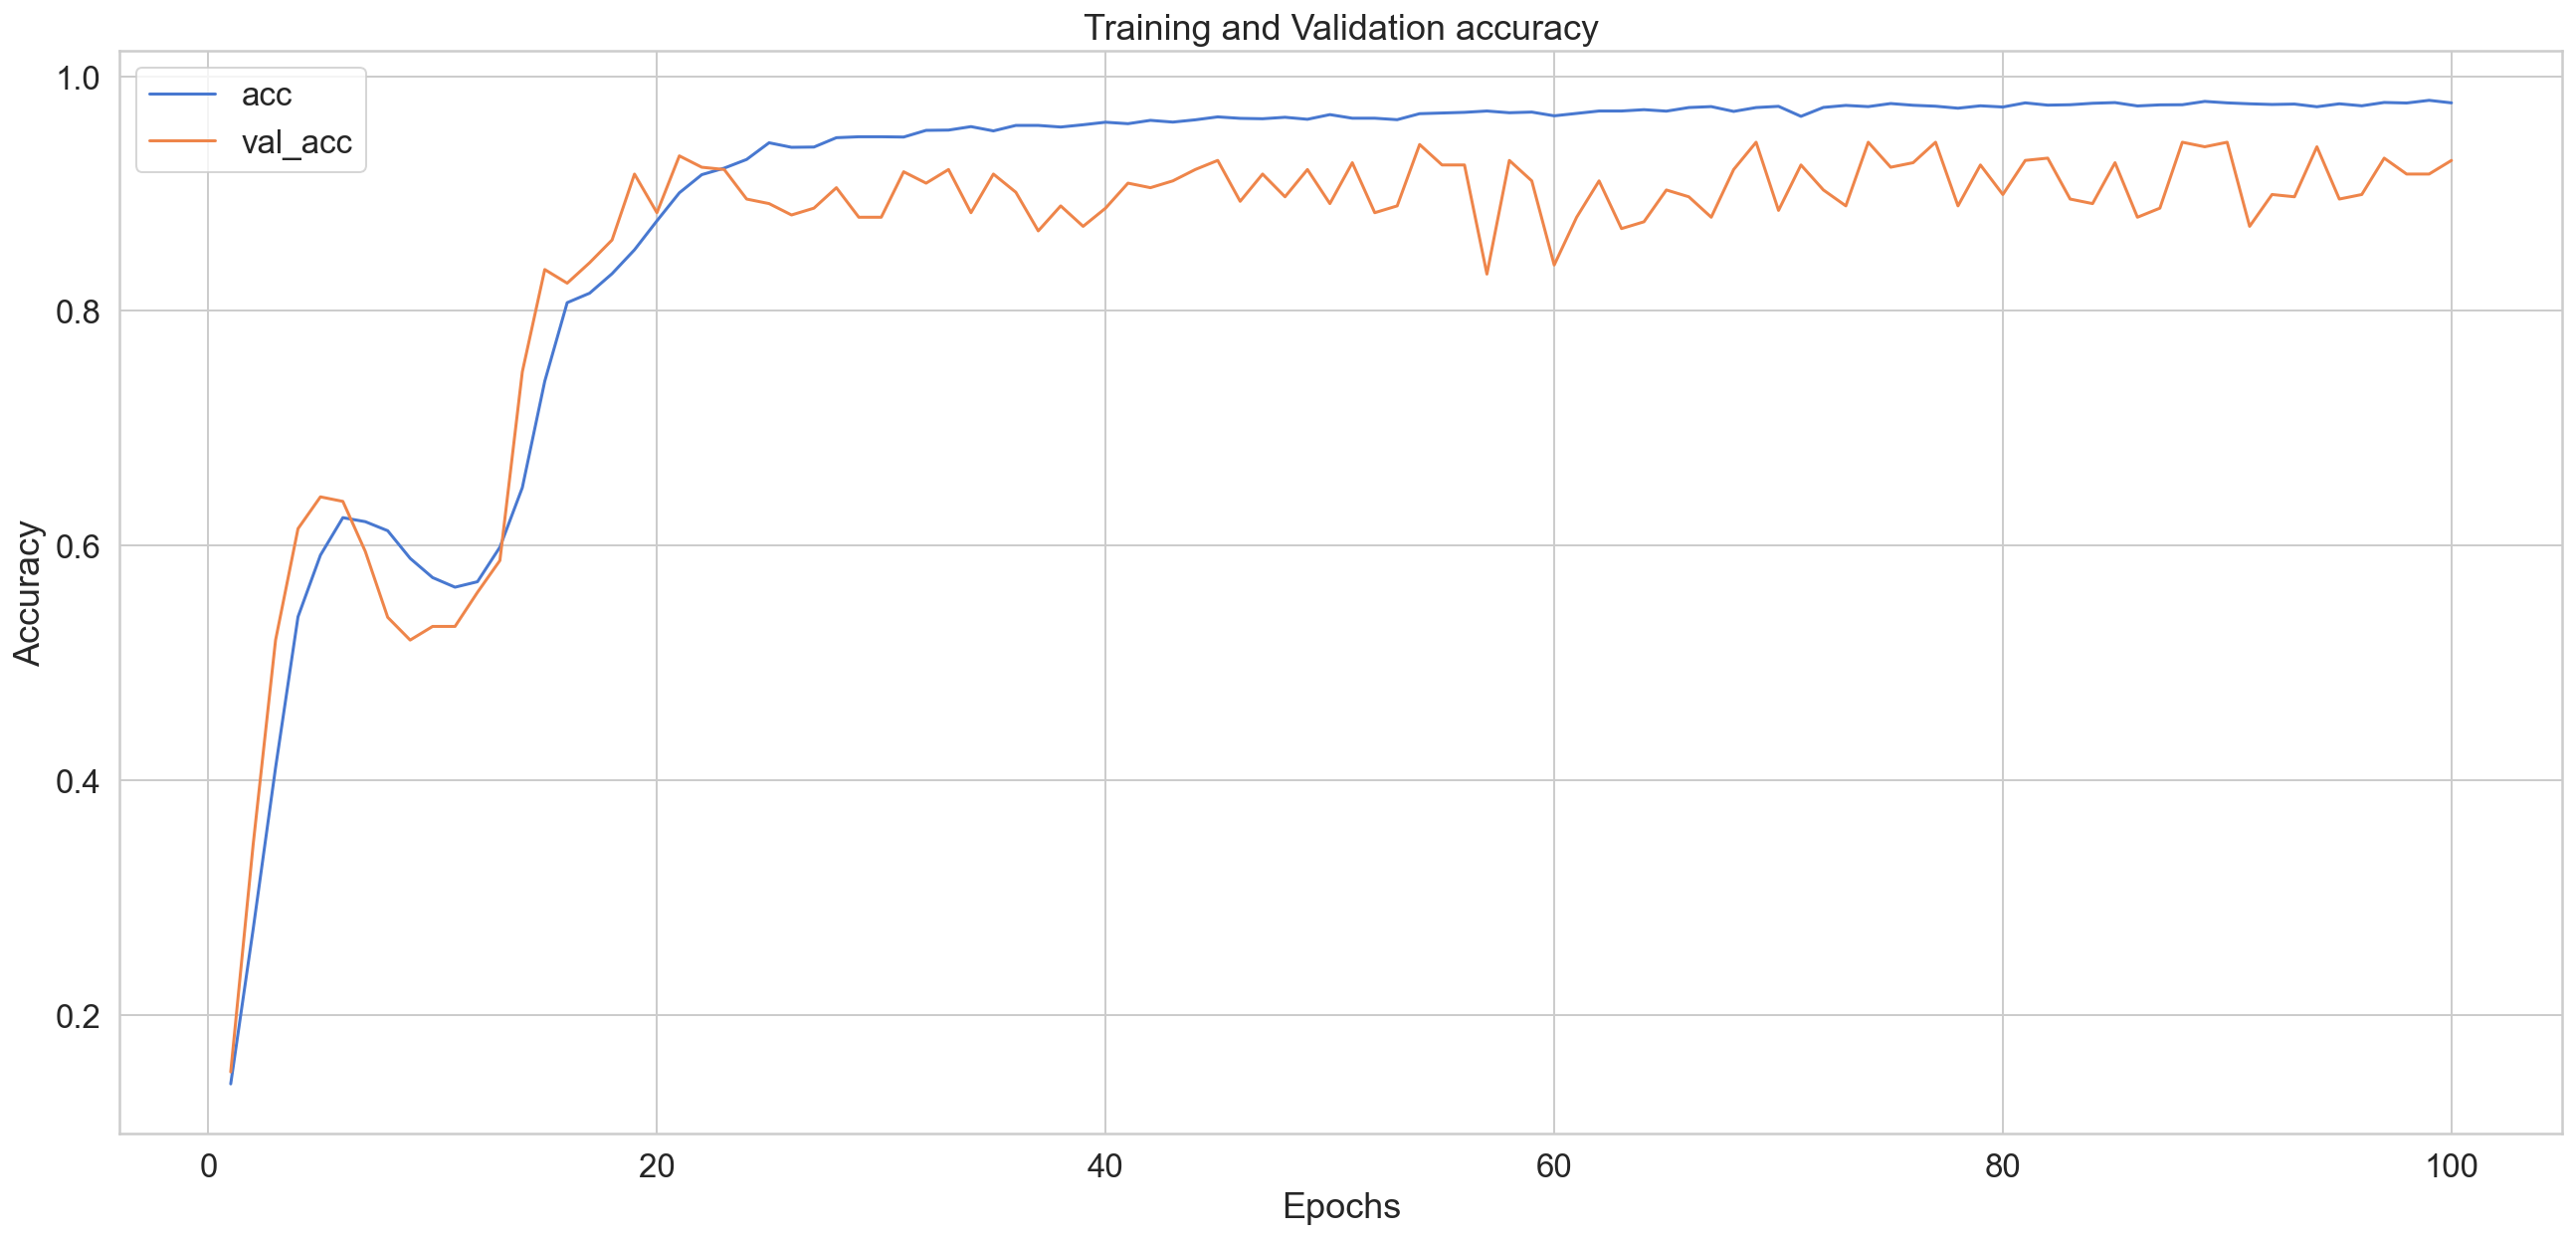

In [34]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1,len(loss_train)+1)
plt.plot(epochs, accuracy_train, label='acc')
plt.plot(epochs, accuracy_val, label='val_acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## CNN

In [35]:
filters = 64
kernel_size = 3
n_features = 6
activation='relu'
n_classes = 5

In [36]:
model = Sequential()

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                 input_shape=(window_size, n_features)))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dropout(0.4))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dropout(0.4))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 64)            1216      
                                                                 
 batch_normalization (BatchN  (None, 48, 64)           256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 64)            0         
                                                                 
 dropout (Dropout)           (None, 48, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 64)            12352     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 64)           256       
 hNormalization)                                      

In [37]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(X_train, y_train,batch_size=256, epochs=50,callbacks=[callback],
                    validation_data=(X_validation, y_validation))

Epoch 1/50


In [ ]:
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

In [ ]:
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the model.
with open('./model/cnn.tflite', 'wb') as f:



    f.write(tflite_model) # INDENT ME

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
sns.set()
f,ax=plt.subplots()
C2= confusion_matrix(y_true_labels, y_pred_labels, labels=[0, 1, 2,3,4])
print(C2) #打印出来看看
sns.heatmap(C2,annot=True,ax=ax) #画热力图

ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴

In [ ]:
myset

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import (
    LSTM,
    Bidirectional,
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Activation,
    Dropout,
)
from hyperactive import Hyperactive, BayesianOptimizer

def lstm(opt):

    nn = keras.Sequential()
    nn.add(keras.layers.Bidirectional(LSTM(units=opt["layers.0"], input_shape=[X_train.shape[1], X_train.shape[2]]
          )
        )
    )

    nn.add(keras.layers.Dropout(rate=opt["dropout.0"]))
    nn.add(keras.layers.Dense(units=opt["neurons.0"], activation='relu'))
    nn.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
    nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    nn.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), shuffle=False)

    _, score = nn.evaluate(x=X_test, y=y_test)

    return score

search_space = {
    "layers.0": [256, 512, 1024, 1256],
    "dropout.0": [0.4, 0.5, 0.6, 0.7, 0.8],
    "neurons.0": list(range(100, 1400))
}


hyper = Hyperactive()
hyper.add_search(lstm, search_space, n_iter=100)
hyper.run()

search_data = hyper.results(lstm)


optimizer = BayesianOptimizer(xi=0.03, warm_start_smbo=search_data, rand_rest_p=0.1)

hyper = Hyperactive()
hyper.add_search(lstm, search_space, optimizer=optimizer, n_iter=5)
hyper.run()